In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from nltk.stem import WordNetLemmatizer

In [78]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [79]:
df = pd.read_csv("/content/Sentiment.csv")

In [24]:
df.columns

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [25]:
df = df[['text','sentiment']]

In [26]:
df.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [27]:
df.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

In [28]:
df.shape

(13871, 2)

In [29]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [30]:
df.drop_duplicates

<bound method DataFrame.drop_duplicates of                                                     text sentiment
0      RT @NancyLeeGrahn: How did everyone feel about...   Neutral
1      RT @ScottWalker: Didn't catch the full #GOPdeb...  Positive
2      RT @TJMShow: No mention of Tamir Rice and the ...   Neutral
3      RT @RobGeorge: That Carly Fiorina is trending ...  Positive
4      RT @DanScavino: #GOPDebate w/ @realDonaldTrump...  Positive
...                                                  ...       ...
13866  RT @cappy_yarbrough: Love to see men who will ...  Negative
13867  RT @georgehenryw: Who thought Huckabee exceede...  Positive
13868  RT @Lrihendry: #TedCruz As President, I will a...  Positive
13869  RT @JRehling: #GOPDebate Donald Trump says tha...  Negative
13870  RT @Lrihendry: #TedCruz headed into the Presid...  Positive

[13871 rows x 2 columns]>

In [31]:
df.shape

(13871, 2)

In [68]:
#Splitting the dataset into train and test set
train, test = train_test_split(df,test_size = 0.1)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

In [84]:
train.shape

(9648, 2)

Positive words


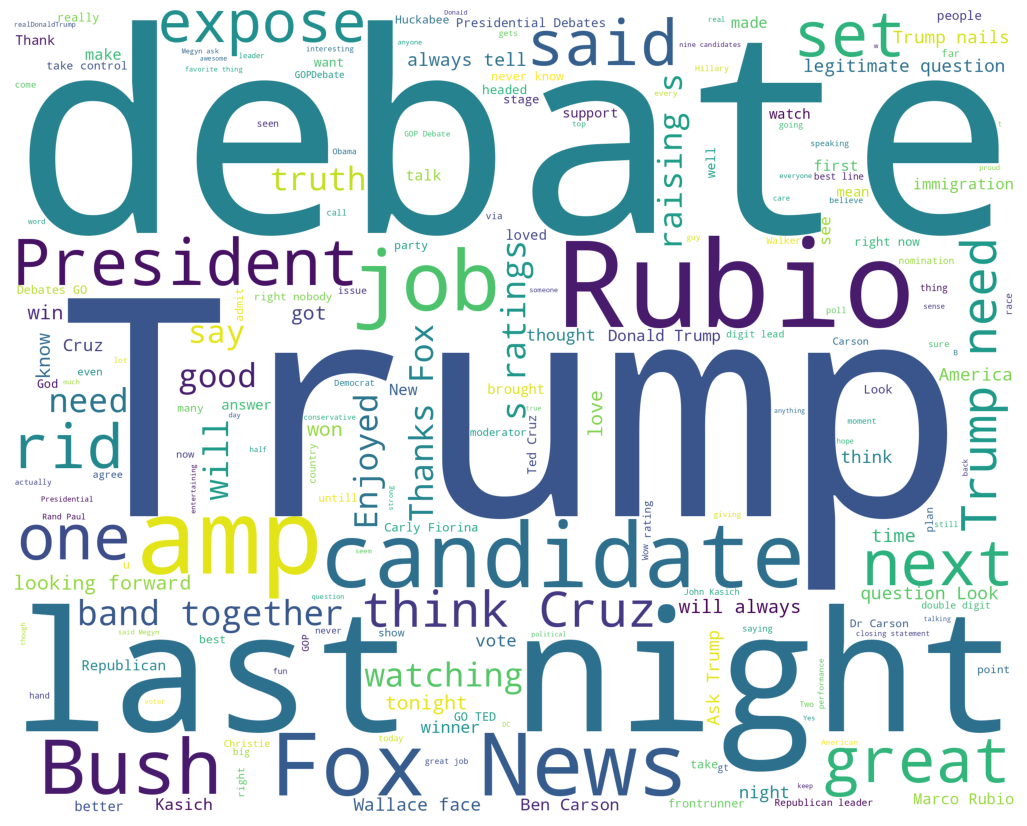

Negative words


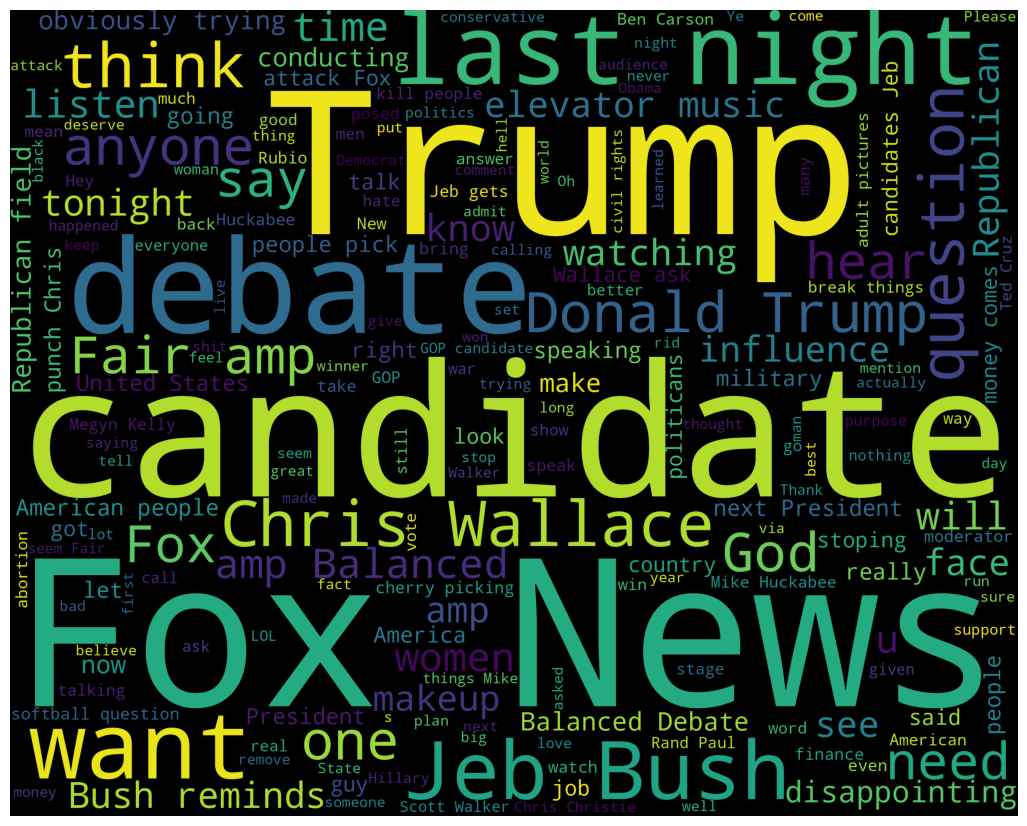

In [89]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [90]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [91]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [92]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [93]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg:
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'):
        neg_cnt = neg_cnt + 1
for obj in test_pos:
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'):
        pos_cnt = pos_cnt + 1

print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))

[Negative]: 860/806 
[Positive]: 221/92 
